In [1]:
#Importing Libraries
import pandas as pd 
import numpy as np 
from sklearn.ensemble import GradientBoostingClassifier
from  sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 12,4

In [2]:
train = pd.read_csv("train_modified.csv", encoding="UTF-8")
test = pd.read_csv("test_modified.csv", encoding = "UTF-8")
target = "Disbursed"
IDcol = "ID" 
predictors = []
for x in train.columns:
    if x not in [target, IDcol]:
        predictors.append(x)
print("Predictors :", predictors)

Predictors : ['Monthly_Income', 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI', 'Var5', 'Var4', 'Age', 'EMI_Loan_Submitted_Missing', 'Interest_Rate_Missing', 'Loan_Amount_Submitted_Missing', 'Loan_Tenure_Submitted_Missing', 'Processing_Fee_Missing', 'Device_Type_0', 'Device_Type_1', 'Filled_Form_0', 'Filled_Form_1', 'Gender_0', 'Gender_1', 'Var1_0', 'Var1_1', 'Var1_2', 'Var1_3', 'Var1_4', 'Var1_5', 'Var1_6', 'Var1_7', 'Var1_8', 'Var1_9', 'Var1_10', 'Var1_11', 'Var1_12', 'Var1_13', 'Var1_14', 'Var1_15', 'Var1_16', 'Var1_17', 'Var1_18', 'Var2_0', 'Var2_1', 'Var2_2', 'Var2_3', 'Var2_4', 'Var2_5', 'Var2_6', 'Mobile_Verified_0', 'Mobile_Verified_1', 'Source_0', 'Source_1', 'Source_2']


In [3]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.8318866 | Std - 0.009559248 | Min - 0.819544 | Max - 0.8438424


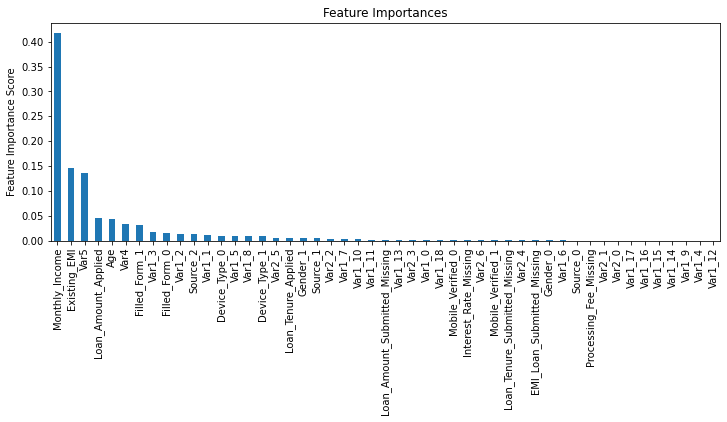

In [4]:
#Choose all predictors except for target and IDCol
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, test, predictors)

In [5]:
#Now we'll perform a grid search on the predictors and find out the optimal number of trees for a particular learning rate.
#We'll be checking the number of trees in range 20 to 80 in steps of 10.
param_test1 = {"n_estimators":range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50, max_depth=8, max_features="sqrt", subsample=0.8, random_state=10), param_grid = param_test1, scoring = "roc_auc", n_jobs=4, cv=5)
gsearch1.fit(train[predictors], train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='roc_auc')

In [6]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 3.64805226,  5.53653994,  6.84139085,  8.58674421, 10.19208198,
         11.77833891, 11.45382309]),
  'std_fit_time': array([0.17845296, 0.37666183, 0.44198598, 0.52776281, 0.5595053 ,
         0.48316067, 2.34825222]),
  'mean_score_time': array([0.06406541, 0.07489605, 0.08312345, 0.10410662, 0.10373597,
         0.12578411, 0.11334476]),
  'std_score_time': array([0.00829035, 0.00681587, 0.00340222, 0.01503221, 0.00422038,
         0.02836492, 0.03947917]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.81783063, 0.8195768 , 0.82372386, 0.8249938 , 0.82409437,
         0.82458748, 0.82169188]),

In [10]:
#From the previous line we can see that at a learning rate of 0.1 optimal number of trees which we have is 70.
# Now we'll perform a grid search
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=70,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='roc_auc')

In [11]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([12.42768288, 11.48511333, 13.81062756, 11.25499172,  8.22581711,
         11.44392352, 11.39317527, 11.174055  , 10.92019181, 10.82840347,
         15.20424423, 17.07633219, 16.47406816, 16.4586226 , 16.57528391,
         21.01304102, 19.64436226, 20.41823578, 18.93923111, 18.62342591,
         24.31967239, 22.84259863, 22.18840833, 21.83961363, 21.44013724,
         26.56381407, 25.75013556, 23.86793761, 23.22844243, 21.00340281]),
  'std_fit_time': array([0.77554237, 0.59009537, 1.9614757 , 1.62858153, 0.30536278,
         0.41722787, 0.44255392, 1.2702934 , 0.38846286, 0.74591458,
         1.28172432, 1.13500475, 1.057493  , 0.80082467, 0.98427697,
         0.77674647, 1.28018012, 0.58391936, 1.69843781, 1.08388911,
         0.63300905, 1.98620951, 1.15038354, 1.63554833, 0.82029276,
         1.40785413, 0.60379998, 0.74169766, 1.15680513, 1.5173965 ]),
  'mean_score_time': array([0.16766696, 0.16983228, 0.13271742, 0.10729771, 0.11156154,
         0.113720

In [14]:
param_test3 = {"min_samples_leaf":range(30,71,10)}
gsearch3 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, max_depth=7, 
                                    min_samples_split=200, max_features="sqrt", subsample=0.8, random_state=10), 
param_grid=param_test3, scoring="roc_auc", n_jobs=5, cv=5)
gsearch3.fit(train[predictors], train[target])

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7,
                                                  max_features='sqrt',
                                                  min_samples_split=200,
                                                  n_estimators=70,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=5, param_grid={'min_samples_leaf': range(30, 71, 10)},
             scoring='roc_auc')